In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
tqdm.monitor_interval = 0
import torch
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
FORECAST = 5
EPS = 120
LAG = 12
SROUTE = SAMPLE_ROUTES[0]
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [4]:
dset = LocalRoute(SROUTE, 'train', 32, lag=LAG).generator()
evalset = LocalRoute(SROUTE, 'test', 32, lag=LAG).generator()

Locals dataset: train
 [*] Loaded routes: 1 (0.23s)
 [*] Has trainable inds: 262262
 [*] Subset train: 212106
Locals dataset: test
 [*] Loaded routes: 1 (0.25s)
 [*] Has trainable inds: 262262
 [*] Subset test: 50156


In [5]:
from models.Linear import Linear

In [6]:
model = Linear(lag=LAG).to(device)
model.device = device

In [7]:
criterion, opt, sch = model.params(lr=0.001)

In [8]:
evaluate(evalset, model, criterion)

Eval loss: 35.95229941971448


In [9]:
losses = []
eval_losses = []
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            loss.item()
        ))
    sys.stdout.write('\n')

    eval_losses.append(evaluate(evalset, model, criterion, result=True))
#     torch.save(model.state_dict(), 'checkpoints/%s_e%d.pth' % (model.name, eii+1))
    sys.stdout.flush()
    sch.step()

[1/120 : 6629/6629] - L2.54        
Eval loss: 7.105815497208006
[2/120 : 6629/6629] - L1.77        
Eval loss: 6.972549575399988
[3/120 : 6629/6629] - L19.19       
Eval loss: 7.5336591729096005
[4/120 : 6629/6629] - L1.05        
Eval loss: 6.930560531740894
[5/120 : 6629/6629] - L3.13        
Eval loss: 6.9155925606586495
[6/120 : 6629/6629] - L4.03        
Eval loss: 6.824951148268823
[7/120 : 6629/6629] - L1.42        
Eval loss: 6.814465263516319
[8/120 : 6629/6629] - L3.38        
Eval loss: 6.725952848297905
[9/120 : 6629/6629] - L1.41        
Eval loss: 6.7437225140022985
[10/120 : 6629/6629] - L1.57        
Eval loss: 6.738240647452827
[11/120 : 6629/6629] - L2.17        
Eval loss: 6.750550260045091
[12/120 : 6629/6629] - L1.24        
Eval loss: 6.73710366296677
[13/120 : 6629/6629] - L1.21        
Eval loss: 6.743447742862057
[14/120 : 6629/6629] - L1.49        
Eval loss: 6.743162907241863
[15/120 : 6629/6629] - L1.61        
Eval loss: 6.739271566803966
[16/120 : 6629/66

Process Process-1137:
Process Process-1138:
Process Process-1139:
Process Process-1140:
Process Process-1135:
Process Process-1136:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args

KeyboardInterrupt: 

2047


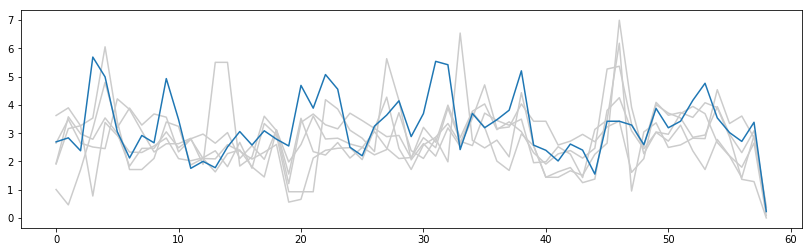

In [32]:
data = history_byname(SROUTE)

sample = data[int(TSTEPS*0.8):]
inds, integs = high_integ(sample[LAG:])
inds += LAG
print(inds[0])
sample = sample[inds[0]-LAG:inds[0]]
for jj, ii in zip(*np.where(np.isnan(sample))):
    sample[jj, ii] = sample[jj-1, ii]
show_context(sample)

In [33]:
preds = []
for bi in range(10, sample.shape[1]+1):
    hist = sample[:, bi-10:bi]
    hist = np.expand_dims(hist, 0)
    hist = torch.from_numpy(hist).to(device).float()
    Xs, _ = model.format_batch(hist)

    yout = model(Xs)
    preds.append(tonpy(yout))

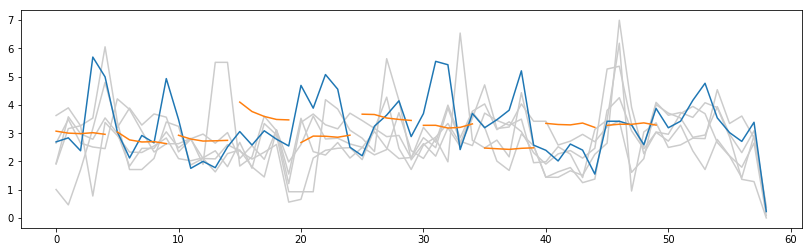

In [34]:
show_context(sample, draw=False)
for bi in range(10, sample.shape[1]+1, 5):
    ylast = np.flip(preds[bi-10][0])
    xpos = list(range(bi-10, bi-5))
    plt.plot(xpos, ylast, color='C1')
plt.show(); plt.close()